In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn
import numpy as np
import random
import pdb
import json

In [5]:
import os
from google.colab import drive
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/colab_files/ai6103/'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
#model location
model_weight_name = "experiment2_senet_resnet_18_se_r_16_lr_0.1_wd_0.0005_momentum_0.9_batch_128_epoch_200.pth"

In [7]:
class ResNet50(nn.Module):
    def __init__(self, block, num_classes=10, r=1):
        super(ResNet50, self).__init__()
        self.block = block
        self.r = r
        self.num_classes = num_classes

        self.stage1 = self.stage_input()
        self.stage2 = self.stage_blocks(2, 64, 64, stride=1)
        self.stage3 = self.stage_blocks(2, 64 * 4, 128, stride=2)
        self.stage4 = self.stage_blocks(2, 128 * 4, 256, stride=2)
        self.stage5 = self.stage_blocks(2, 256 * 4, 512, stride=2)
        self.stage6 = self.stage_output(512 * 4, self.num_classes)

    def forward(self, x):
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.stage5(x)
        x = self.stage6(x)
        return x

    def stage_input(self):
        conv = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        bn = nn.BatchNorm2d(64)
        relu = nn.ReLU()
        pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        return nn.Sequential(conv, bn, relu, pool)

    def stage_blocks(self, n, in_channels, out_channels, stride=1):
        layers = [self.block(in_channels, out_channels, stride=stride, r=self.r)]
        for i in range(n - 1):
            layers.append(self.block(out_channels * 4, out_channels, r=self.r))
        return nn.Sequential(*layers)

    def stage_output(self, in_channels, out_channels, stride=1):
        pool = nn.AdaptiveAvgPool2d((1, 1))
        flatten = nn.Flatten()
        fc = nn.Linear(in_channels, out_channels)
        return nn.Sequential(pool, flatten, fc)


class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, r=1):
        super(ResNetBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, out_channels * 4, kernel_size=1, stride=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * 4)

        self.relu = nn.ReLU()

        self.need_downsample = stride != 1 or in_channels != out_channels * 4
        if self.need_downsample:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * 4, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * 4)
            )
        else:
            self.downsample = None

    def forward(self, x):
        identity = x

        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))

        if self.need_downsample:
            identity = self.downsample(identity)

        out = x + identity
        out = self.relu(out)

        return out


class SEBlock(nn.Module):
    def __init__(self, channel, r):
        super(SEBlock, self).__init__()
        reductionChannel = channel // r
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(channel, reductionChannel)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(reductionChannel, channel)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # pdb.set_trace()
        out = self.pool(x)
        batch, channel = out.size(0), out.size(1)
        out = out.view(batch, -1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = out.view(batch, channel, 1, 1)
        out = self.sigmoid(out)
        return out


class SEResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, r=1):
        super(SEResNetBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, out_channels * 4, kernel_size=1, stride=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * 4)

        self.relu = nn.ReLU()

        self.need_downsample = stride != 1 or in_channels != out_channels * 4
        if self.need_downsample:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * 4, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * 4)
            )
        else:
            self.downsample = None

        self.seBlock = SEBlock(out_channels * 4, r)

    def forward(self, x):
        identity = x

        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))

        if self.need_downsample:
            identity = self.downsample(identity)

        # apply SE
        scale = self.seBlock(x)

        out = x * scale.expand_as(x) + identity
        out = self.relu(out)

        return out

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
def get_middle_features(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook

def get_middle_features_withPrint(name):
    def hook(model, input, output):
        features[name] = output.detach()
        print(input)
        print(np.squeeze(np.squeeze(input.cpu().numpy(), axis = 2), axis = 2))
    return hook

In [13]:
model = torch.load(data_dir + model_weight_name)
model = model.to(device)

model.stage2[0].seBlock.sigmoid.register_forward_hook(get_middle_features('stage2_0'))
model.stage2[1].seBlock.sigmoid.register_forward_hook(get_middle_features('stage2_1'))

model.stage3[0].seBlock.sigmoid.register_forward_hook(get_middle_features('stage3_0'))
model.stage3[1].seBlock.sigmoid.register_forward_hook(get_middle_features('stage3_1'))

model.stage4[0].seBlock.sigmoid.register_forward_hook(get_middle_features('stage4_0'))
model.stage4[1].seBlock.sigmoid.register_forward_hook(get_middle_features('stage4_1'))

model.stage5[0].seBlock.sigmoid.register_forward_hook(get_middle_features('stage5_0'))
model.stage5[1].seBlock.sigmoid.register_forward_hook(get_middle_features('stage5_1'))

In [19]:
key_set = ['stage2_0', 'stage2_1', 'stage3_0', 'stage3_1', 'stage4_0', 'stage4_1', 'stage5_0', 'stage5_1']
label_set = [i for i in range(10)]

In [20]:
batch_size = 1

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
])

# Download CIFAR-10 testing dataset
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified


In [21]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [22]:
extracted_features_all = []
model.eval()  # Set the model to evaluation mode

with torch.no_grad():
  for inputs, labels in test_loader:
    features = {}
    inputs, labels = inputs.to(device), labels.to(device)
    # test
    outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)

    features['predicted_label'] = predicted
    features['actual_label'] = labels
    extracted_features_all.append(features)
    # print(inputs.cpu().numpy())
    # print(np.squeeze(np.squeeze(features['stage2_0'].cpu().numpy(), axis = 2), axis = 2))



In [23]:
feature_of_class = {}
for data in extracted_features_all:
  label = data['actual_label'].item()
  if(label not in feature_of_class.keys()):
    feature_of_class[label] = {"features":{}, "count":0}
    for key in key_set:
      feature_of_class[label]["features"][key] = []

  for key in key_set:
    stage_feature = data[key].cpu().numpy()
    stage_fearure_squeezed = np.squeeze(np.squeeze(stage_feature, axis = 2), axis = 2)
    feature_of_class[label]["features"][key].append(stage_fearure_squeezed)
  #print( np.squeeze(np.squeeze(data['stage2_0'].cpu().numpy(), axis = 2), axis = 2))
  feature_of_class[label]["count"] += 1

In [24]:
label = 0
key = 'stage2_0'

In [25]:
import matplotlib.pyplot as plt

In [26]:
def plotAvgFeatureAtStage(feature_of_class, label, key):
  features = np.concatenate(feature_of_class[label]["features"][key])
  avg = np.mean(features, axis = 0)
  x = [i for i in range(len(avg))]
  plt.plot(x, avg, label=("label:" + str(label) + " key:" + key), linewidth=0.3, alpha=0.7)
  plt.xlabel('channel')
  plt.ylabel('activation')

def plotAllFeatureAtStage(feature_of_class, label, key, linewidth=0.1, alpha=0.05):
  features = np.concatenate(feature_of_class[label]["features"][key])

  x = [i for i in range(len(features[0]))]
  for feature in features:
    plt.plot(x, feature, linewidth=0.1, alpha=0.05)
  plt.xlabel('channel')
  plt.ylabel('activation')

#Checking average activation on each channel for each class
However, it seems that activation on each channel is almost the same

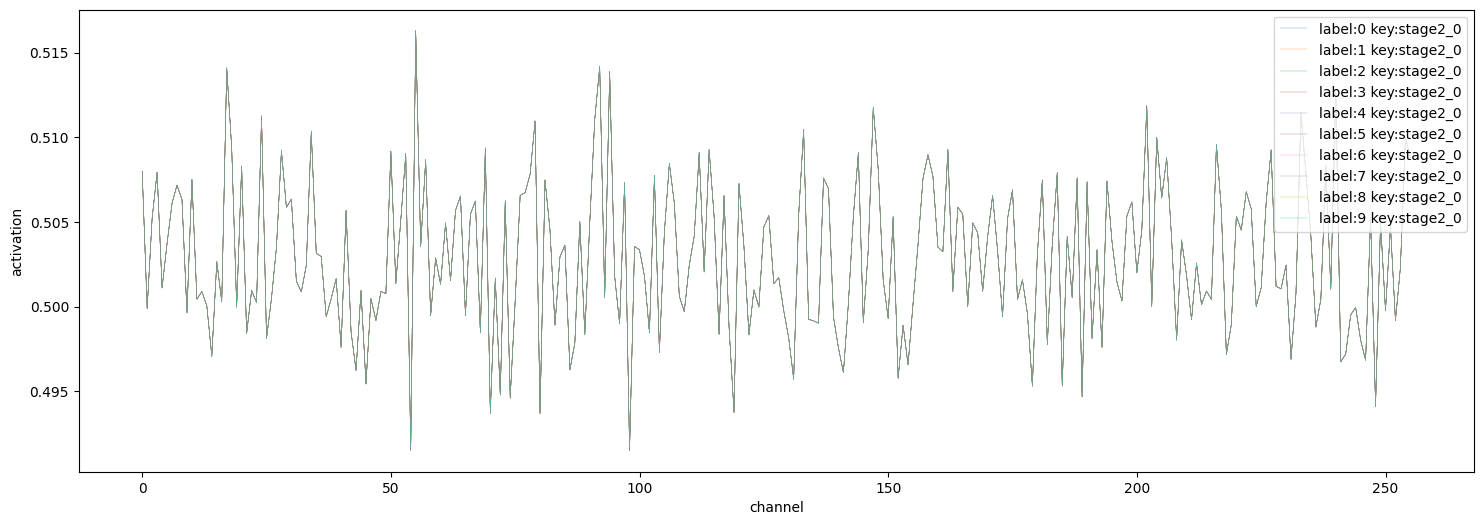

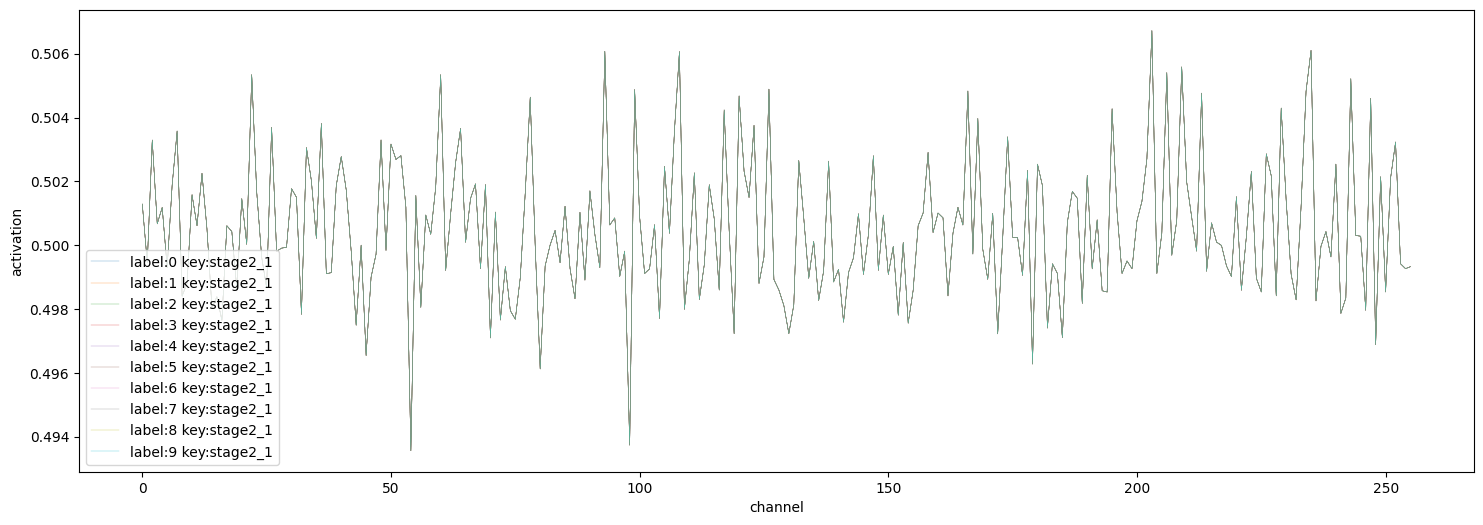

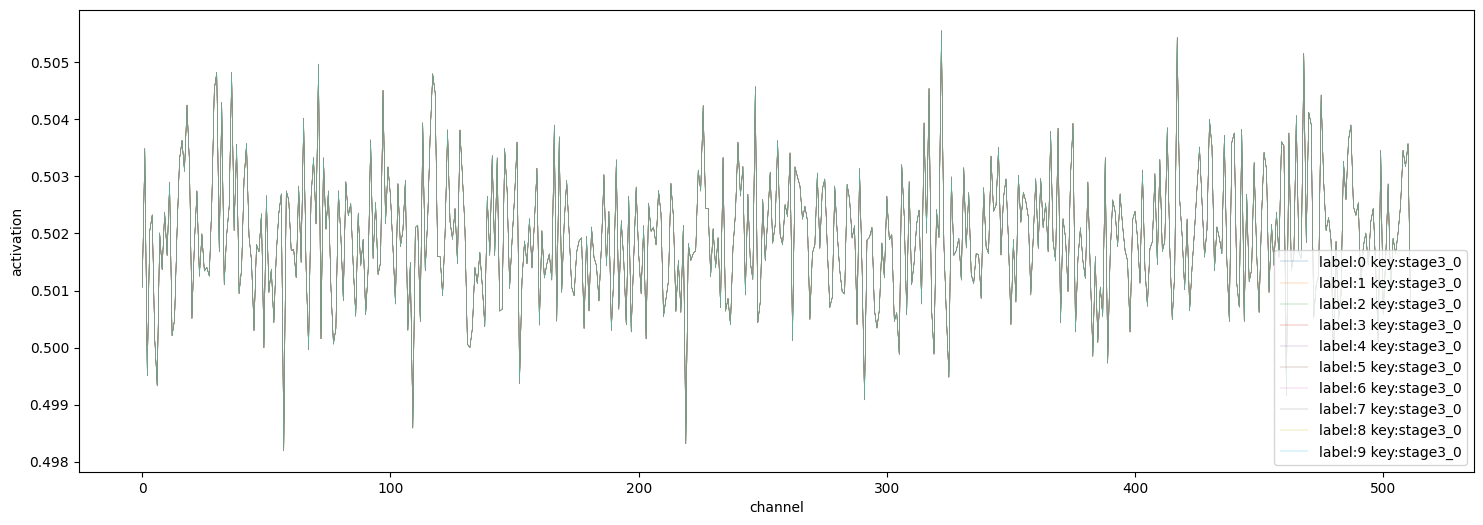

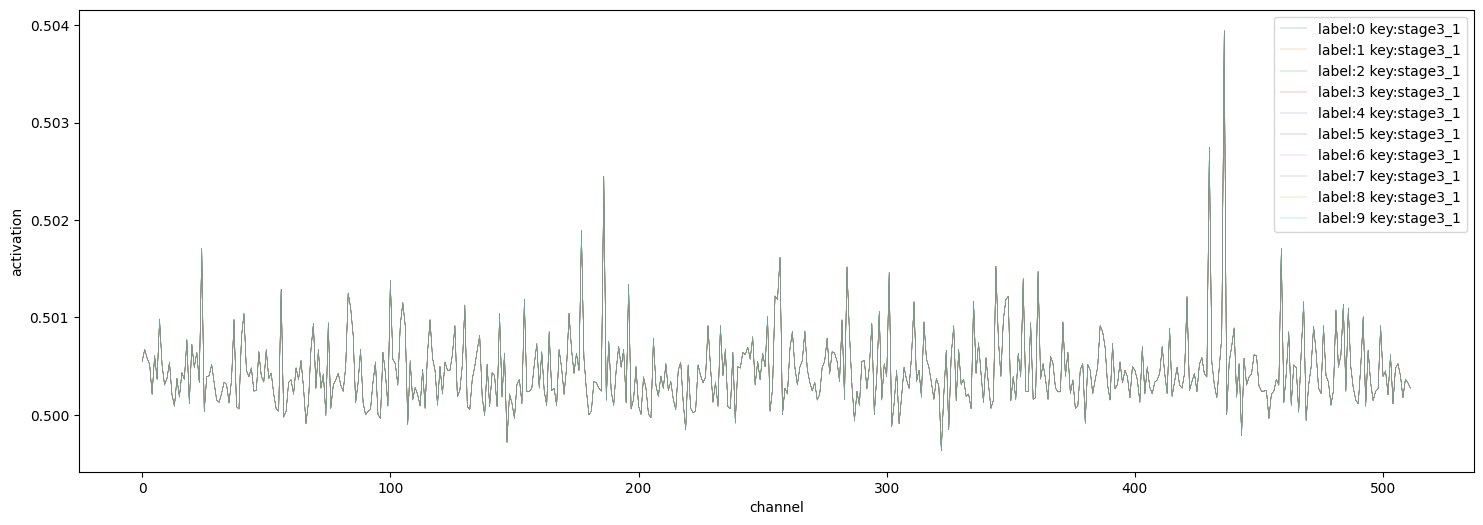

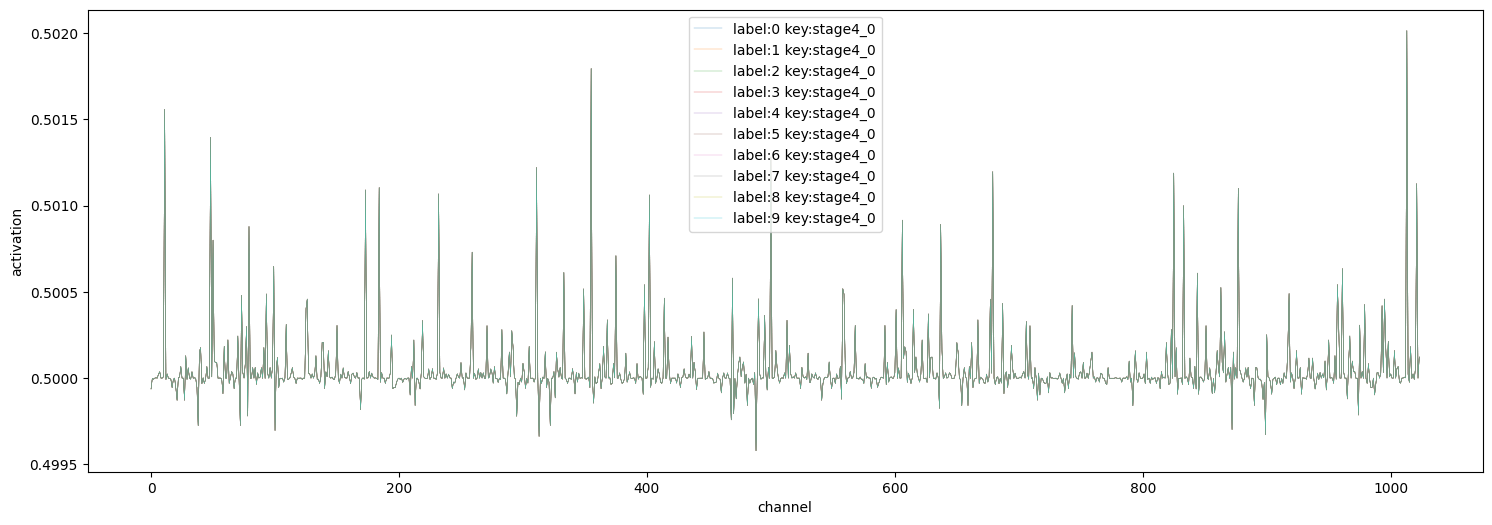

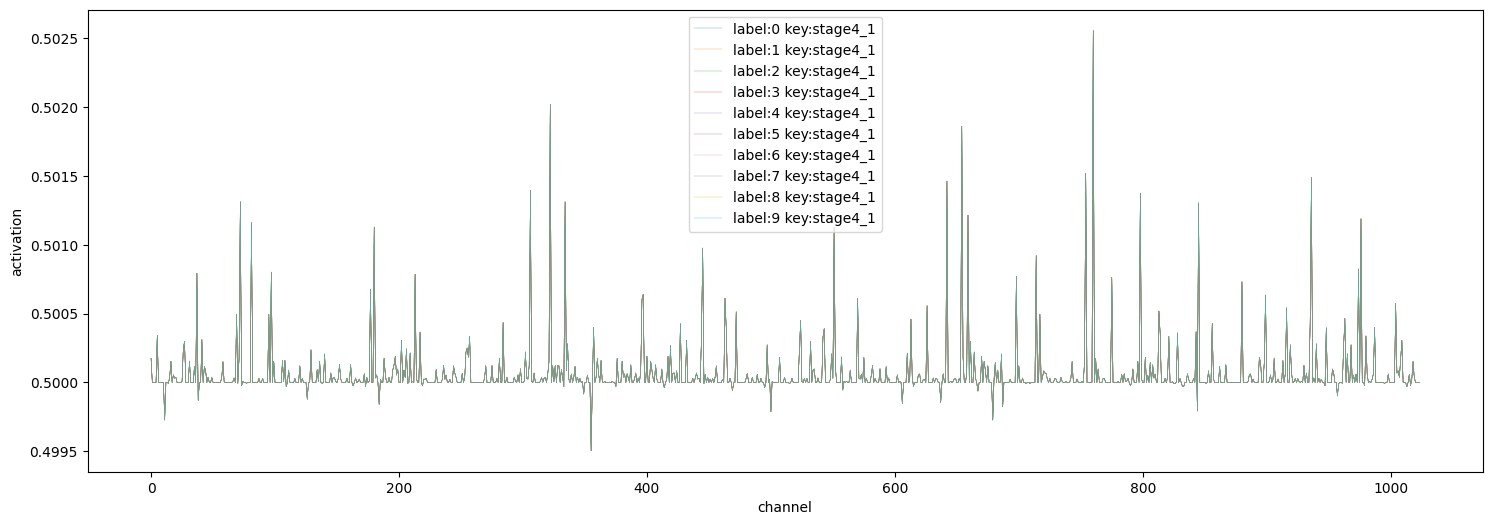

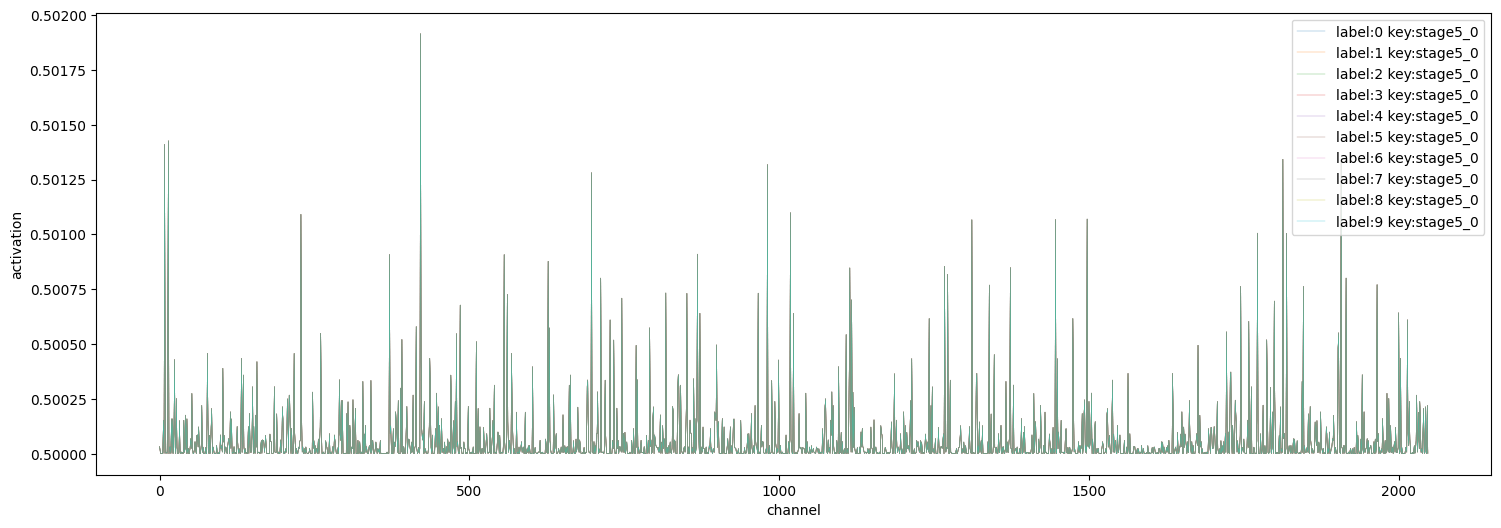

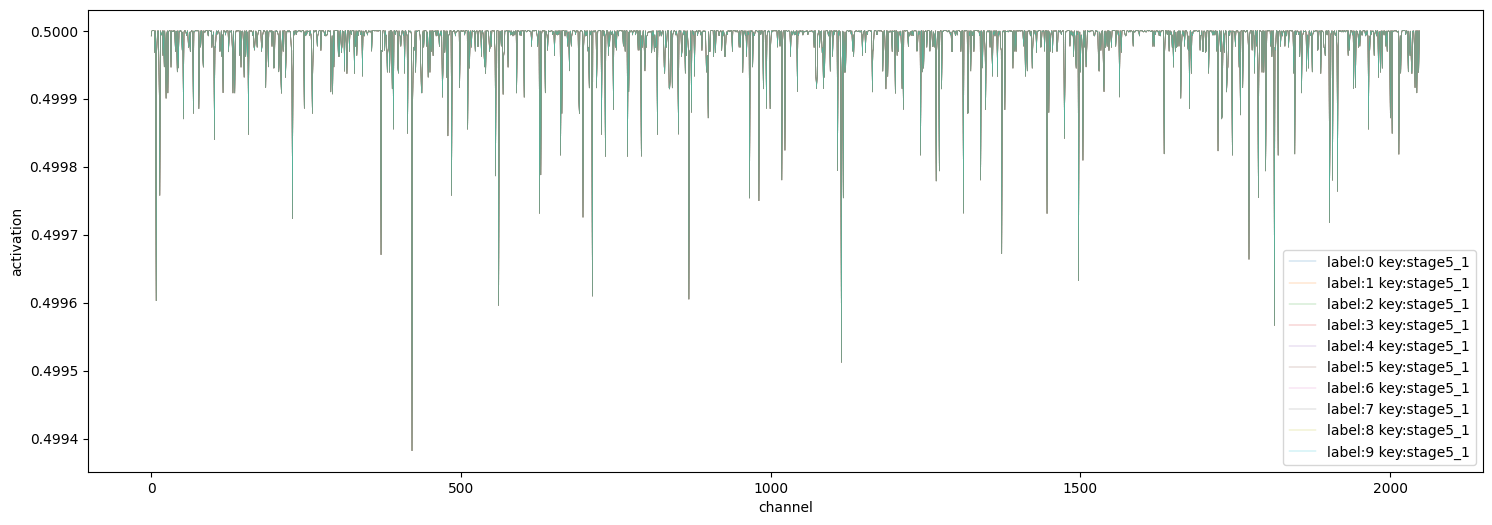

In [27]:
for key in key_set:
  plt.figure(figsize=(18, 6))
  for label in label_set:
    plotAvgFeatureAtStage(feature_of_class, label, key)
  plt.legend()
  plt.show()

#Checking activate on a single class

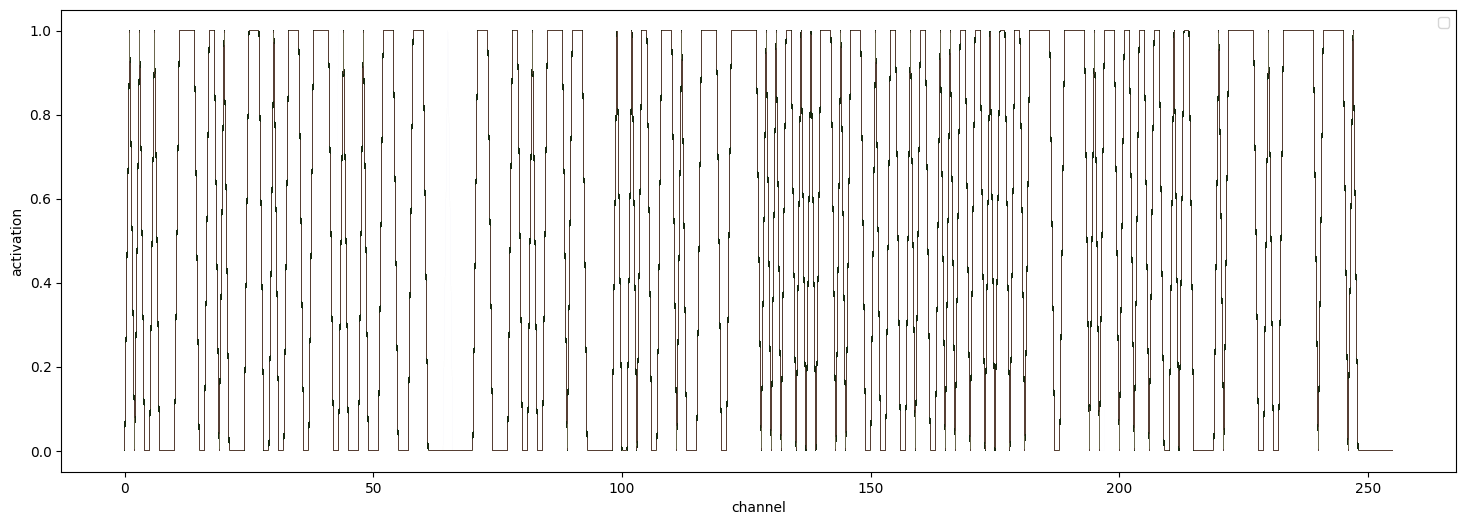

In [ ]:
plt.figure(figsize=(18, 6))
plotAllFeatureAtStage(feature_of_class, label, key, linewidth=0.3, alpha=1)
plt.legend()
plt.show()

In [ ]:
#extract all feature on channel for a single block and a single class
label = 0
key = 'stage2_0'

unique_lists_set = set()
for feature in feature_of_class[label]["features"][key]:
  unique_lists_set.add(tuple(feature.tolist()[0]))
test_arr = np.array(list(unique_lists_set))

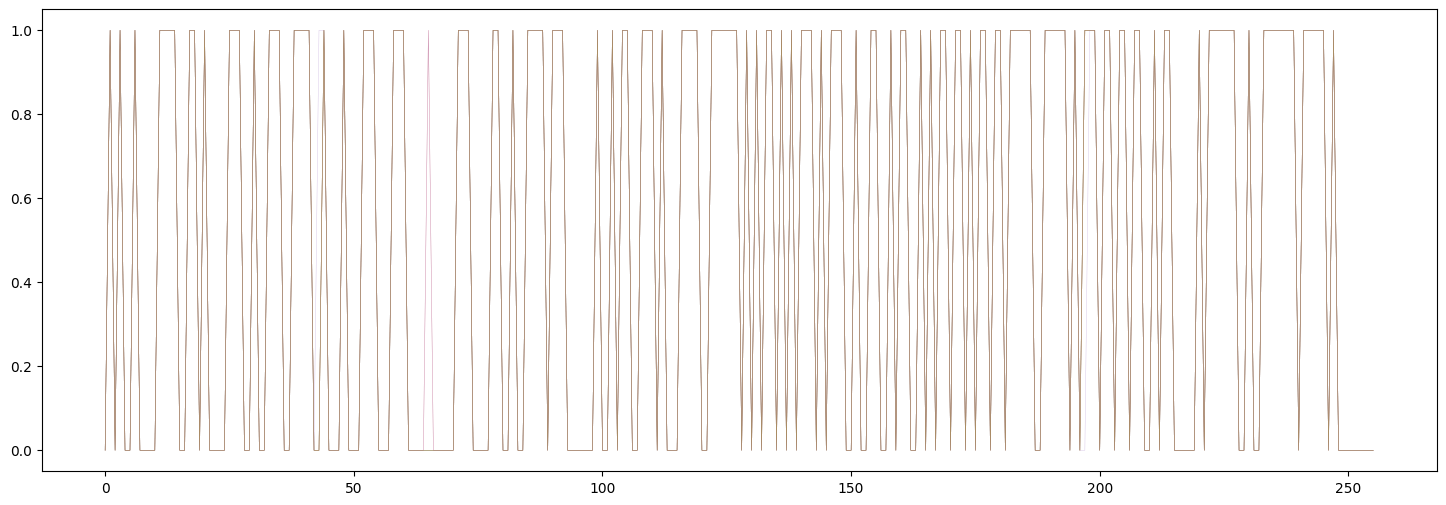

In [ ]:
plt.figure(figsize=(18, 6))
x = [i for i in range(256)]
for i in range(len(test_arr)):
  plt.plot(x, test_arr[i, :], linewidth=0.3, alpha=0.4)

a pink stike is observed around 60th channel\
in some ways the activation can have difference

In [ ]:
max_diff = 0
for i in range(len(test_arr)):
  diff = np.abs(test_arr[0, :] - test_arr[i, :])
  max_diff = max(max_diff, np.max(diff))
max_diff

1.0

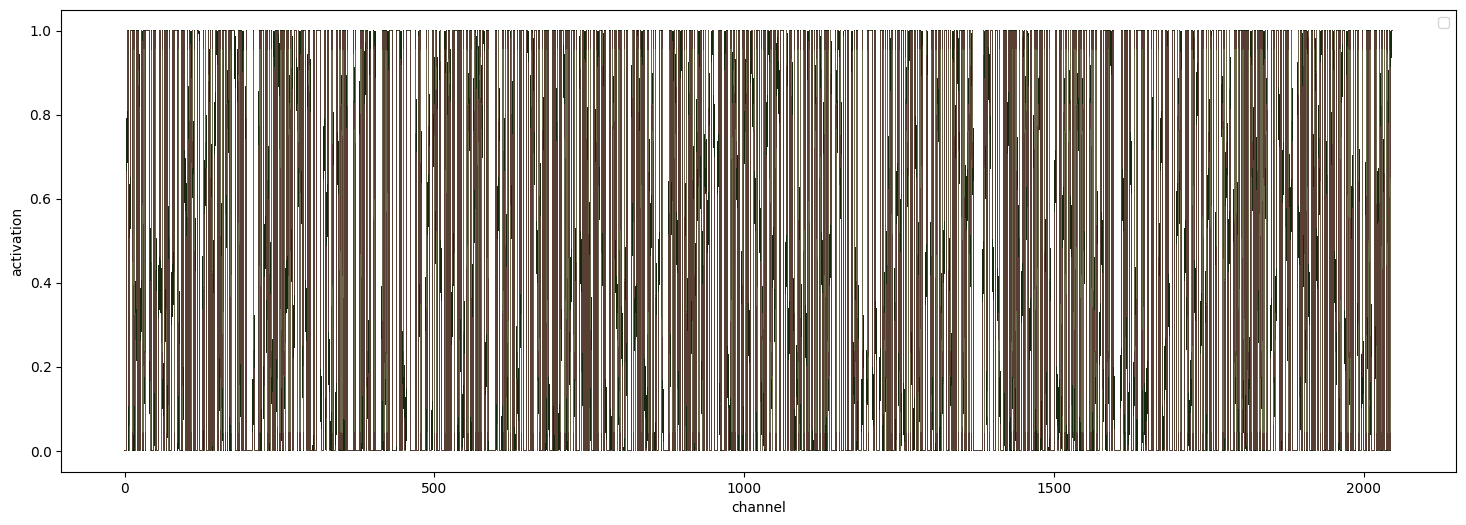

In [ ]:
plt.figure(figsize=(18, 6))
plotAllFeatureAtStage(feature_of_class, label, key, alpha=0.05)
plt.legend()
plt.show()